In [2]:
!python -m pip install numpy matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import matplotlib.pyplot as plt


In [4]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.7 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

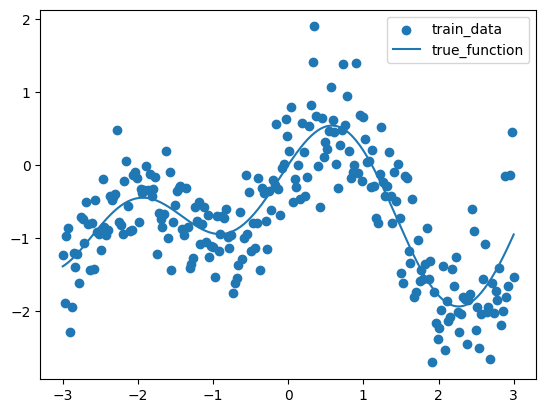

In [5]:
rng = np.random.default_rng(42)

N = 250
x = np.linspace(-3, 3, N)

sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [6]:
lamb = 1.0
alpha = 1.0 / (sigma ** 2)

M = X.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)

In [7]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X.T @ y)

In [8]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

mean_pred = X_new @ mean
var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
std_pred = np.sqrt(var_pred)

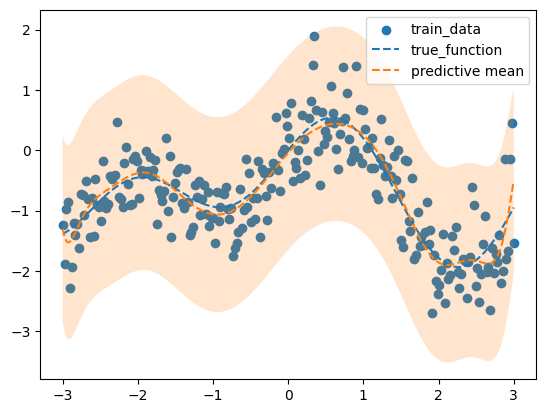

In [9]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

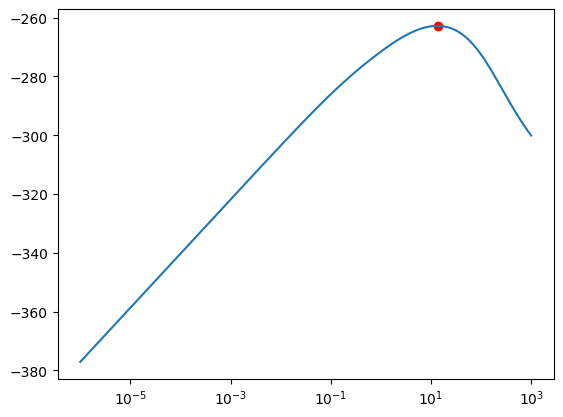

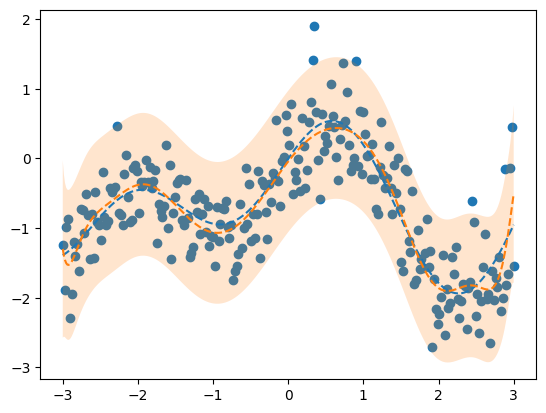

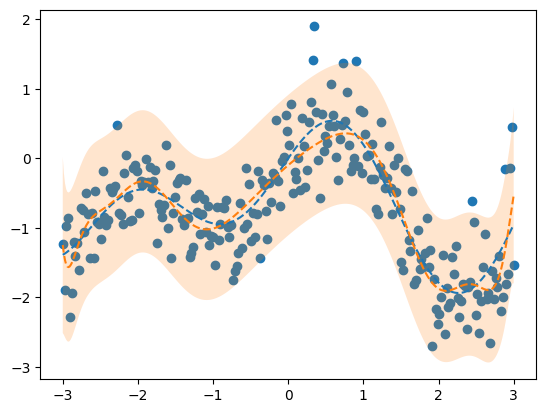

Лучшая lambda: 13.5542
Макс log-evidence: -262.820


In [10]:
rng = np.random.default_rng(42)
N = 250
x = np.linspace(-3, 3, N)
sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)
alpha = 1.0 / (sigma ** 2)

def log_evidence(lamb, X, y, alpha, return_params=False):
    '''
    Тут надо написать расчет log-evidence, через формулу, которая была в лекции
    Далее взять какой-то набор лямбд (например np.logspace(-6, 3, 160)) и оценить для каждой эту функцию
    Получится лучшая лябмда
    Вывести график log-evidence vs lambda + графики, чтобы визуально сравнить предсказания базовой модели и модели с лучшей лямбдой
    '''
    N, M = X.shape
    S_inv = lamb * np.eye(M) + alpha * (X.T @ X)
    L = np.linalg.cholesky(S_inv)
    logdet_Sinv = 2.0 * np.sum(np.log(np.diag(L)))
    rhs = alpha * (X.T @ y)
    z = np.linalg.solve(L, rhs)
    m_N = np.linalg.solve(L.T, z)
    S_N = np.linalg.solve(L.T, np.linalg.solve(L, np.eye(M)))
    resid = y - X @ m_N
    data_fit = alpha * np.dot(resid, resid)
    complexity = lamb * np.dot(m_N, m_N)
    logev = 0.5 * (M*np.log(lamb) + N*np.log(alpha) 
                   - logdet_Sinv - data_fit - complexity) \
            - 0.5 * N * np.log(2*np.pi)
    if return_params:
        return float(logev), m_N, S_N
    return float(logev)

def predict_bayes(X_new, m_N, S_N, alpha):
    mean = X_new @ m_N
    S_phi = X_new @ S_N
    var = (1.0/alpha) + np.einsum('ij,ij->i', S_phi, X_new)
    return mean, np.sqrt(var)

lamb_grid = np.logspace(-6, 3, 160)
logev_values = np.array([log_evidence(lmb, X, y, alpha) for lmb in lamb_grid])
best_idx = np.argmax(logev_values)
lamb_best = lamb_grid[best_idx]

_, m_base, S_base = log_evidence(1.0, X, y, alpha, return_params=True)
_, m_best, S_best = log_evidence(lamb_best, X, y, alpha, return_params=True)

x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)
mean_base, std_base = predict_bayes(X_new, m_base, S_base, alpha)
mean_best, std_best = predict_bayes(X_new, m_best, S_best, alpha)

# График log-evidence
plt.figure()
plt.semilogx(lamb_grid, logev_values)
plt.scatter([lamb_best], [logev_values[best_idx]], c='red')
plt.show()

# График базовой модели
plt.figure()
plt.scatter(x, y)
plt.plot(x_new, f_true(x_new), '--')
plt.plot(x_new, mean_base, '--')
plt.fill_between(x_new, mean_base-2*std_base, mean_base+2*std_base, alpha=0.2)
plt.show()

# График модели с лучшей lambda
plt.figure()
plt.scatter(x, y)
plt.plot(x_new, f_true(x_new), '--')
plt.plot(x_new, mean_best, '--')
plt.fill_between(x_new, mean_best-2*std_best, mean_best+2*std_best, alpha=0.2)
plt.show()

print(f"Лучшая lambda: {lamb_best:.6g}")
print(f"Макс log-evidence: {logev_values[best_idx]:.3f}")